In [214]:
from pykrx import stock
import pandas as pd
import mplfinance as mpf
import numpy as np
import plotly.graph_objects as go
import plotly.subplots as ms
import plotly.express as px

In [215]:
# pip install pykrx
# pip install mplfinance

In [216]:
# 전체 종목코드와 종목명 가져오기
stock_list = pd.DataFrame({'종목코드':stock.get_market_ticker_list(market="ALL")})
stock_list['종목명'] = stock_list['종목코드'].map(lambda x: stock.get_market_ticker_name(x))

In [217]:
name_list = list(stock_list['종목명'])

dff = pd.DataFrame()
stock_from = "20210702" # 2249~2301
stock_to = "20220701"

for name in name_list:
    stock_name = name
    ticker = stock_list.loc[stock_list['종목명']== stock_name, '종목코드']
    df = stock.get_market_ohlcv_by_date(fromdate=stock_from, todate=stock_to, ticker=ticker)
# 칼럼명을 영문명으로 변경
    df['name'] = name
    df["종가"]=df["종가"].apply(pd.to_numeric,errors="coerce")
    dff = pd.concat([dff,df])
dff = dff.rename(columns={'시가':'Open', '고가':'High', '저가':'Low', '종가':'Close', '거래량':'Volume'})

In [218]:
# 특정 날이 존재하는 종목 리스트 뽑기 

df = dff

dname = df[stock_from]['name']
dname = list(dname.values)
dff = pd.DataFrame()

for name in dname:
    stock_name = name
    ticker = stock_list.loc[stock_list['종목명']== stock_name, '종목코드']
    df = stock.get_market_ohlcv_by_date(fromdate=stock_from, todate=stock_to, ticker=ticker)
    df = df.assign(종목명=stock_name)
# 칼럼명을 영문명으로 변경
    df["종가"]=df["종가"].apply(pd.to_numeric,errors="coerce")
    dff = pd.concat([dff,df])
dff = dff.rename(columns={'시가':'Open', '고가':'High', '저가':'Low', '종가':'Close', '거래량':'Volume'})

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """


In [219]:
# 지표 데이터 프레임 만들기
df = dff

df['ma20'] = df['Close'].rolling(window=20).mean() # 20일 이동평균
df['stddev'] = df['Close'].rolling(window=20).std() # 20일 이동표준편차
df['upper'] = df['ma20'] + 2*df['stddev'] # 상단밴드
df['lower'] = df['ma20'] - 2*df['stddev'] # 하단밴드

df['ma12'] = df['Close'].rolling(window=12).mean() # 12일 이동평균
df['ma26'] = df['Close'].rolling(window=26).mean() # 26일 이동평균
df['MACD'] = df['ma12'] - df['ma26']    # MACD
df['MACD_Signal'] = df['MACD'].rolling(window=9).mean() # MACD Signal(MACD 9일 이동평균)
df['MACD_Oscil'] = df['MACD'] - df['MACD_Signal']   #MACD 오실레이터

df['ndays_high'] = df['High'].rolling(window=14, min_periods=1).max()    # 14일 중 최고가
df['ndays_low'] = df['Low'].rolling(window=14, min_periods=1).min()      # 14일 중 최저가
df['fast_k'] = (df['Close'] - df['ndays_low']) / (df['ndays_high'] - df['ndays_low']) * 100  # Fast %K 구하기
df['slow_d'] = df['fast_k'].rolling(window=3).mean()    # Slow %D 구하기

#RSI 구하기
U = np.where(df['Close'].diff(1) > 0, df['Close'].diff(1), 0)
D = np.where(df['Close'].diff(1) < 0, df['Close'].diff(1) *(-1), 0)
AU = pd.DataFrame(U, index=df.index).rolling(window=14).mean()
AD = pd.DataFrame(D, index=df.index).rolling(window=14).mean()
RSI = AU / (AD+AU) *100
df['RSI'] = RSI

# cci 구하기
df['M'] = 0.0
df['m'] = 0.0
df['D'] = 0.0
df['CCI'] = 0.0

df['M'] = (df['High']+df['Low']+df['Close'])/3

df['m'] = df['M'].rolling(window=20).mean()
df['D'] = (df['M'] - df['m']).rolling(window=20).mean()
df['CCI'] = (df['M']-df['m'])/(0.015*df['D'])

df

,Open,High,Low,Close,Volume,종목명,ma20,stddev,upper,lower,...,MACD_Oscil,ndays_high,ndays_low,fast_k,slow_d,RSI,M,m,D,CCI
날짜,,,,,,,,,,,,,,,,,,,,,
2021-07-02,3110,3250,3105,3155,394731,3S,NaN,NaN,NaN,NaN,...,NaN,3250.0,3105.0,34.482759,NaN,NaN,3170.000000,NaN,NaN,NaN
2021-07-05,3155,3180,3100,3150,139527,3S,NaN,NaN,NaN,NaN,...,NaN,3250.0,3100.0,33.333333,NaN,NaN,3143.333333,NaN,NaN,NaN
2021-07-06,3150,3150,3090,3120,160550,3S,NaN,NaN,NaN,NaN,...,NaN,3250.0,3090.0,18.750000,28.855364,NaN,3120.000000,NaN,NaN,NaN
2021-07-07,3130,3130,3065,3100,124051,3S,NaN,NaN,NaN,NaN,...,NaN,3250.0,3065.0,18.918919,23.667417,NaN,3098.333333,NaN,NaN,NaN
2021-07-08,3100,3105,3010,3045,160385,3S,NaN,NaN,NaN,NaN,...,NaN,3250.0,3010.0,14.583333,17.417417,NaN,3053.333333,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-27,6030,6270,6030,6260,11825,힘스,7186.0,816.671034,8819.342068,5552.657932,...,-306.267806,8090.0,5650.0,25.000000,16.898409,16.793893,6186.666667,7192.333333,-638.825000,104.949625
2022-06-28,6160,6290,6160,6290,9326,힘스,7101.5,817.623481,8736.746962,5466.253038,...,-297.934473,8000.0,5650.0,27.234043,22.602604,17.803030,6246.666667,7105.500000,-667.275000,85.805036
2022-06-29,6280,6280,6110,6240,7290,힘스,7015.0,812.400600,8639.801201,5390.198799,...,-267.998575,7900.0,5650.0,26.222222,26.152088,18.076923,6210.000000,7018.333333,-694.308333,77.615213


In [221]:
# MFI 구하기

# 여기서 구할수잇나? MFI

len_a = (len(df[df['종목명'] == dname[0]])-38)

df['MF'] = 0
df['MF'] = df['Volume']*df['M']
df['MF_sign'] = 0 

for _ in range(1, len(df)):
    if _%len_a == 0:
        continue
    if df['MF'][_] - df['MF'][_-1] == 0:
        df['MF_sign'][_] = 0
    elif df['MF'][_] - df['MF'][_-1] > 0:
        df['MF_sign'][_] = 1
    elif df['MF'][_] - df['MF'][_-1] < 0:
        df['MF_sign'][_] = -1
        
df

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


,Open,High,Low,Close,Volume,종목명,ma20,stddev,upper,lower,...,ndays_low,fast_k,slow_d,RSI,M,m,D,CCI,MF,MF_sign
날짜,,,,,,,,,,,,,,,,,,,,,
2021-07-02,3110,3250,3105,3155,394731,3S,NaN,NaN,NaN,NaN,...,3105.0,34.482759,NaN,NaN,3170.000000,NaN,NaN,NaN,1.251297e+09,0
2021-07-05,3155,3180,3100,3150,139527,3S,NaN,NaN,NaN,NaN,...,3100.0,33.333333,NaN,NaN,3143.333333,NaN,NaN,NaN,4.385799e+08,-1
2021-07-06,3150,3150,3090,3120,160550,3S,NaN,NaN,NaN,NaN,...,3090.0,18.750000,28.855364,NaN,3120.000000,NaN,NaN,NaN,5.009160e+08,1
2021-07-07,3130,3130,3065,3100,124051,3S,NaN,NaN,NaN,NaN,...,3065.0,18.918919,23.667417,NaN,3098.333333,NaN,NaN,NaN,3.843513e+08,-1
2021-07-08,3100,3105,3010,3045,160385,3S,NaN,NaN,NaN,NaN,...,3010.0,14.583333,17.417417,NaN,3053.333333,NaN,NaN,NaN,4.897089e+08,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-27,6030,6270,6030,6260,11825,힘스,7186.0,816.671034,8819.342068,5552.657932,...,5650.0,25.000000,16.898409,16.793893,6186.666667,7192.333333,-638.825000,104.949625,7.315733e+07,-1
2022-06-28,6160,6290,6160,6290,9326,힘스,7101.5,817.623481,8736.746962,5466.253038,...,5650.0,27.234043,22.602604,17.803030,6246.666667,7105.500000,-667.275000,85.805036,5.825641e+07,-1
2022-06-29,6280,6280,6110,6240,7290,힘스,7015.0,812.400600,8639.801201,5390.198799,...,5650.0,26.222222,26.152088,18.076923,6210.000000,7018.333333,-694.308333,77.615213,4.527090e+07,-1


In [1]:
df['MFI'] = 0

positive = []
negative = []

for _ in range(len(df)-14):
    for i in range(14):
        if df['Volume'][_+i] == 0:
            break
        elif df['MF_sign'][_+i] == -1:
            negative.append(df['MF'][_+i])
        elif df['MF_sign'][_+i] == 1:
            positive.append(df['MF'][_+i])
    if sum(negative) != 0:
        MFR = sum(positive)/sum(negative)
        df['MFI'][_+14] = 100-100/(1+MFR)
    positive = []
    negative = []
df

NameError: name 'df' is not defined

In [223]:
!pwd

/home/work


In [189]:
# 보조지표 계산에 필요한 NAN값 제거 
df = df.reset_index(drop=False, inplace = False)

a = [0]*38
b = [1]*(len(df[df['종목명'] == dname[0]])-38)
print(b)
c = (a+b)*len(dname)
c = pd.DataFrame(c)

df['bool'] = c
df = df[df['bool'] == 1]

df = df.reset_index(drop=False, inplace = False)
df

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


,index,날짜,Open,High,Low,Close,Volume,종목명,ma20,stddev,...,slow_d,RSI,M,m,D,CCI,MF,MF_sign,MFI,bool
0,38,2021-08-26,3350,3380,3305,3380,154459,3S,3522.25,265.223218,...,30.487289,34.519573,3355.000000,3516.666667,117.454167,-91.761562,5.182099e+08,1,23,1
1,39,2021-08-27,3380,3575,3325,3465,631108,3S,3533.25,257.571017,...,36.590038,34.982332,3455.000000,3527.250000,108.679167,-44.320055,2.180478e+09,1,30,1
2,40,2021-08-30,3535,3550,3420,3445,264200,3S,3541.50,251.605895,...,44.374156,38.823529,3471.666667,3537.666667,99.450000,-44.243338,9.172143e+08,-1,44,1
3,41,2021-08-31,3445,3480,3365,3445,180374,3S,3521.75,242.271460,...,51.809779,40.573770,3430.000000,3524.916667,69.045833,-91.646048,6.186828e+08,-1,50,1
4,42,2021-09-01,3445,3530,3410,3490,161173,3S,3499.75,222.411869,...,58.314279,45.762712,3476.666667,3503.333333,32.858333,-54.104320,5.603448e+08,-1,54,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521867,617209,2022-06-27,6030,6270,6030,6260,11825,힘스,7186.00,816.671034,...,16.898409,16.793893,6186.666667,7192.333333,-638.825000,104.949625,7.315733e+07,-1,73,1
521868,617210,2022-06-28,6160,6290,6160,6290,9326,힘스,7101.50,817.623481,...,22.602604,17.803030,6246.666667,7105.500000,-667.275000,85.805036,5.825641e+07,-1,70,1
521869,617211,2022-06-29,6280,6280,6110,6240,7290,힘스,7015.00,812.400600,...,26.152088,18.076923,6210.000000,7018.333333,-694.308333,77.615213,4.527090e+07,-1,68,1
521870,617212,2022-06-30,6260,6270,6120,6270,4520,힘스,6926.00,790.245797,...,28.417046,20.080321,6220.000000,6927.833333,-722.558333,65.308068,2.811440e+07,-1,65,1


In [190]:
# 거래량 0인적 있는 데이터 제거 

name_list = list(df[df['Volume'] == 0]['종목명'].unique())

# name_list는 volume = 0 인적 잇는것들 
for n in name_list:
    df = df[df['종목명'] != n ]
    
df = df.reset_index(drop=False, inplace = False)
df

,level_0,index,날짜,Open,High,Low,Close,Volume,종목명,ma20,...,slow_d,RSI,M,m,D,CCI,MF,MF_sign,MFI,bool
0,0,38,2021-08-26,3350,3380,3305,3380,154459,3S,3522.25,...,30.487289,34.519573,3355.000000,3516.666667,117.454167,-91.761562,5.182099e+08,1,23,1
1,1,39,2021-08-27,3380,3575,3325,3465,631108,3S,3533.25,...,36.590038,34.982332,3455.000000,3527.250000,108.679167,-44.320055,2.180478e+09,1,30,1
2,2,40,2021-08-30,3535,3550,3420,3445,264200,3S,3541.50,...,44.374156,38.823529,3471.666667,3537.666667,99.450000,-44.243338,9.172143e+08,-1,44,1
3,3,41,2021-08-31,3445,3480,3365,3445,180374,3S,3521.75,...,51.809779,40.573770,3430.000000,3524.916667,69.045833,-91.646048,6.186828e+08,-1,50,1
4,4,42,2021-09-01,3445,3530,3410,3490,161173,3S,3499.75,...,58.314279,45.762712,3476.666667,3503.333333,32.858333,-54.104320,5.603448e+08,-1,54,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462587,521867,617209,2022-06-27,6030,6270,6030,6260,11825,힘스,7186.00,...,16.898409,16.793893,6186.666667,7192.333333,-638.825000,104.949625,7.315733e+07,-1,73,1
462588,521868,617210,2022-06-28,6160,6290,6160,6290,9326,힘스,7101.50,...,22.602604,17.803030,6246.666667,7105.500000,-667.275000,85.805036,5.825641e+07,-1,70,1
462589,521869,617211,2022-06-29,6280,6280,6110,6240,7290,힘스,7015.00,...,26.152088,18.076923,6210.000000,7018.333333,-694.308333,77.615213,4.527090e+07,-1,68,1
462590,521870,617212,2022-06-30,6260,6270,6120,6270,4520,힘스,6926.00,...,28.417046,20.080321,6220.000000,6927.833333,-722.558333,65.308068,2.811440e+07,-1,65,1


In [191]:
Base_data = df

Base_data['BOL_trade'] = 0 # 밴드의 상한 및 하한선 벗어날 때
Base_data['MACD_trade'] = 0 # 음->양 매수 양->음 매도 
Base_data['RSI_trade'] = 0 # 70이상 매도 , 30이하 매수 
Base_data['CCI_trade'] = 0 # -100 ->상향 매수, 100 -> 하향 매도 
Base_data['STO_trade'] = 0 # k가 d를 상향 돌파, 매수 / k가 d를 하향 돌파 매도 
Base_data['MFI_trade'] = 0 # 20이하로 떨어지면 매수 , 80이상으로 가면 매도 

BOL_c = 0
MACD_c = 0
RSI_c = 0
CCI_c = 0
STO_c = 0
MFI_c = 0


# 볼린저밴드 upper, lower 
# macd = MACD_Oscil
# sto = fast_k, slow_d
# RSI
# CCI

# MFI
Alpha = 0
for i in range(len(Base_data)):
    if Alpha == 0:
        if Base_data['MFI'][i] < 20:
            Alpha = -1
    if Base_data['MFI'][i] > 20:
        if Alpha == -1:
            Base_data['MFI_trade'][i] = 1
            MFI_c += 1
            Alpha = 0
    if Alpha == 0:           
        if Base_data['MFI'][i] > 80:
            Alpha = 1 
    if Base_data['MFI'][i] < 80:
        if Alpha == 1:
            Base_data['MFI_trade'][i] = 2
            Alpha = 0
            MFI_c += 1
            

Alpha = 0 
for i in range(len(Base_data)):
    if Alpha == 0:
        if Base_data['CCI'][i] < -1:
            Alpha = -1 
    if Alpha == -1:
        if Base_data['CCI'][i] > -1:
            Base_data['CCI_trade'][i] = 1
            CCI_c += 1
            Alpha = 0
            
    if Alpha == 0:        
        if Base_data['CCI'][i] > 1:
            Alpha = 1
    if Alpha == 1:
        if Base_data['CCI'][i] < 1:
            Base_data['CCI_trade'][i] = 2
            CCI_c += 1
            Alpha = 0
 
Alpha = 0
for i in range(len(Base_data)):
    if Alpha == 0:
        if Base_data['Close'][i] < Base_data['lower'][i]: # 종가가 하한선보다 작다면 
            Alpha = -1 
    if Base_data['Close'][i] > Base_data['lower'][i]:
        if Alpha == -1:
            Base_data['BOL_trade'][i] = 1
            BOL_c += 1
            Alpha = 0 
            
    if Alpha == 0:
        if Base_data['Close'][i] > Base_data['upper'][i]: # 종가가 하한선보다 크면
            Alpha = 1
    if Base_data['Close'][i] < Base_data['upper'][i]:
        if Alpha == 1:
            Base_data['BOL_trade'][i] = 2
            BOL_c += 1
            Alpha = 0
            
Alpha = 0
for i in range(len(Base_data)):
    if Alpha == 0:
        if Base_data['MACD_Oscil'][i] < 0:
            Alpha = -1
    if Base_data['MACD_Oscil'][i] > 0:
        if Alpha == -1:
            Base_data['MACD_trade'][i] = 1
            MACD_c += 1
            Alpha = 0
            
    if Alpha == 0:           
        if Base_data['MACD_Oscil'][i] > 0:
            Alpha = 1
    if Base_data['MACD_Oscil'][i] < 0:
        if Alpha == 1:
            Base_data['MACD_trade'][i] = 2
            MACD_c += 1
            Alpha = 0
            
Alpha = 0
for i in range(len(Base_data)):
    if Alpha == 0:
        if Base_data['RSI'][i] < 30:
            Alpha = -1
    if Base_data['RSI'][i] > 30:
        if Alpha == -1:
            Base_data['RSI_trade'][i] = 1
            RSI_c += 1
            Alpha = 0
    if Alpha == 0:           
        if Base_data['RSI'][i] > 70:
            Alpha = 1 
    if Base_data['RSI'][i] < 70:
        if Alpha == 1:
            Base_data['RSI_trade'][i] = 2
            RSI_c += 1
            Alpha = 0
    
Alpha = 0
for i in range(len(Base_data)):
    if Alpha == 0:
        if Base_data['fast_k'][i] < Base_data['slow_d'][i]:
            Alpha = -1
    if Alpha == -1:
        if Base_data['fast_k'][i] > Base_data['slow_d'][i]:
            Base_data['STO_trade'][i] = 1
            STO_c += 1
            Alpha = 0
            
    if Alpha == 0:
        if Base_data['fast_k'][i] > Base_data['slow_d'][i]:
            Alpha = 1
    if Alpha == 1:
        if Base_data['fast_k'][i] < Base_data['slow_d'][i]:
            Base_data['STO_trade'][i] = 2
            STO_c += 1
            Alpha = 0


Base_data

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to b

,level_0,index,날짜,Open,High,Low,Close,Volume,종목명,ma20,...,MF,MF_sign,MFI,bool,BOL_trade,MACD_trade,RSI_trade,CCI_trade,STO_trade,MFI_trade
0,0,38,2021-08-26,3350,3380,3305,3380,154459,3S,3522.25,...,5.182099e+08,1,23,1,0,0,0,0,0,0
1,1,39,2021-08-27,3380,3575,3325,3465,631108,3S,3533.25,...,2.180478e+09,1,30,1,0,0,0,0,0,0
2,2,40,2021-08-30,3535,3550,3420,3445,264200,3S,3541.50,...,9.172143e+08,-1,44,1,0,0,0,0,0,0
3,3,41,2021-08-31,3445,3480,3365,3445,180374,3S,3521.75,...,6.186828e+08,-1,50,1,0,0,0,0,0,0
4,4,42,2021-09-01,3445,3530,3410,3490,161173,3S,3499.75,...,5.603448e+08,-1,54,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462587,521867,617209,2022-06-27,6030,6270,6030,6260,11825,힘스,7186.00,...,7.315733e+07,-1,73,1,0,0,0,0,0,0
462588,521868,617210,2022-06-28,6160,6290,6160,6290,9326,힘스,7101.50,...,5.825641e+07,-1,70,1,0,0,0,0,0,0
462589,521869,617211,2022-06-29,6280,6280,6110,6240,7290,힘스,7015.00,...,4.527090e+07,-1,68,1,0,0,0,0,0,0
462590,521870,617212,2022-06-30,6260,6270,6120,6270,4520,힘스,6926.00,...,2.811440e+07,-1,65,1,0,0,0,0,0,0


In [192]:
trade_data = Base_data

trade_data['BOL_profit']= 0
trade_data['MACD_profit']= 0
trade_data['RSI_profit']= 0
trade_data['CCI_profit']= 0
trade_data['STO_profit']= 0

trade_data['MFI_profit'] = 0

trade_data['Ori']= 0


# 한 종목 개수 
len_a = len(b)
start_m = 30000000 # 시작 돈 
plus_m = 3000000 # 월급 

# 0-대기 1-매수 2-매도
def trade(data, asset, indicator):
    day = 0
    ori = 0
    count = 0 
    can_b = 0
    can_s = 0
    for _ in range(len(data)-1):
        if _%len_a == 0:
            day = 0
            ori = 0
            count = 0 
            can_b = 0
            can_s = 0
            asset = start_m
        if day != 0:
            if day%30 == 0:
                ori += 1
                day = 0 
                asset += plus_m
        if data[indicator + '_trade'][_] == 0:
            data[indicator + '_profit'][_] = asset + (count*data['Close'][_])
        elif data[indicator + '_trade'][_] == 1:
            can_b = int(asset / data['Open'][_+1])
            asset -= can_b*data['Open'][_+1]
            count += can_b 
            data[indicator + '_profit'][_] = asset + (count*data['Close'][_])
            can_b = 0
        elif data[indicator + '_trade'][_] == 2:
            can_s = int(count/2)
            asset += can_s*data['Open'][_+1]
            count -= can_s
            data[indicator + '_profit'][_] = asset + (count*data['Close'][_])
            can_s = 0
        data['Ori'][_] = start_m + (ori)*plus_m
        day += 1
    return data

trade_data = trade(trade_data, start_m, "BOL")
trade_data = trade(trade_data, start_m, "MACD")
trade_data = trade(trade_data, start_m, "RSI")
trade_data = trade(trade_data, start_m, "CCI")
trade_data = trade(trade_data, start_m, "STO")

trade_data = trade(trade_data, start_m, "MFI")

trade_data

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to b

,level_0,index,날짜,Open,High,Low,Close,Volume,종목명,ma20,...,CCI_trade,STO_trade,MFI_trade,BOL_profit,MACD_profit,RSI_profit,CCI_profit,STO_profit,MFI_profit,Ori
0,0,38,2021-08-26,3350,3380,3305,3380,154459,3S,3522.25,...,0,0,0,30000000,30000000,30000000,30000000,30000000,30000000,30000000
1,1,39,2021-08-27,3380,3575,3325,3465,631108,3S,3533.25,...,0,0,0,30000000,30000000,30000000,30000000,30000000,30000000,30000000
2,2,40,2021-08-30,3535,3550,3420,3445,264200,3S,3541.50,...,0,0,0,30000000,30000000,30000000,30000000,30000000,30000000,30000000
3,3,41,2021-08-31,3445,3480,3365,3445,180374,3S,3521.75,...,0,0,0,30000000,30000000,30000000,30000000,30000000,30000000,30000000
4,4,42,2021-09-01,3445,3530,3410,3490,161173,3S,3499.75,...,0,0,0,30000000,30000000,30000000,30000000,30000000,30000000,30000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462587,521867,617209,2022-06-27,6030,6270,6030,6260,11825,힘스,7186.00,...,0,0,0,34531630,32895420,31218460,32399290,37895920,48000000,48000000
462588,521868,617210,2022-06-28,6160,6290,6160,6290,9326,힘스,7101.50,...,0,0,0,34697110,32972640,31368040,32540170,38077510,48000000,48000000
462589,521869,617211,2022-06-29,6280,6280,6110,6240,7290,힘스,7015.00,...,0,0,0,34421310,32843940,31118740,32305370,37774860,48000000,48000000
462590,521870,617212,2022-06-30,6260,6270,6120,6270,4520,힘스,6926.00,...,0,0,0,34586790,32921160,31268320,32446250,37956450,48000000,48000000


In [193]:
# 맞췄을까? 

trade_data['BOL_bool'] = 0
trade_data['MACD_bool'] = 0
trade_data['RSI_bool'] = 0
trade_data['CCI_bool'] = 0
trade_data['STO_bool'] = 0

trade_data['MFI_bool'] = 0

trade_data['trend'] = 0 

for _ in range(1, len(trade_data)):
    if _%len_a == 0:
        continue
    if trade_data['Close'][_] - trade_data['Close'][_-1] == 0:
        trade_data['trend'][_] = 0
    elif trade_data['Close'][_] - trade_data['Close'][_-1] > 0:
        trade_data['trend'][_] = 1
    elif trade_data['Close'][_] - trade_data['Close'][_-1] < 0:
        trade_data['trend'][_] = -1
        
# trend가 나왔고, 
def gogo(data, indicator):
    state = 0
    for _ in range(len(data)-1):
        if _%len_a == 0:
            state = 0
        # state check
        if data[indicator + '_trade'][_] == 1:
            state = 1 # 매수 상태 
        elif data[indicator + '_trade'][_] == 2:
            state = 2 # 매도 상태
        # state 별로 값 할당 
        if state == 0:
            if data[indicator + '_trade'][_] == 0:
                data[indicator + '_bool'][_] = state
        elif state == 1: # 매수 상태
            # 1 or -1
            if data['trend'][_] >= 0 :
                data[indicator + '_bool'][_] = 1
            else:
                data[indicator + '_bool'][_] = -1
        elif state == 2: # 매도 상태 
            if data['trend'][_] <= 0 :
                data[indicator + '_bool'][_] = 1
            else:
                data[indicator + '_bool'][_] = -1
    return data

gogo(trade_data, 'BOL')
gogo(trade_data, 'MACD')
gogo(trade_data, 'RSI')
gogo(trade_data, 'CCI')
gogo(trade_data, 'STO')
gogo(trade_data, 'MFI')


# 1이 맞춘거, -1이 틀린것 

print(len(trade_data[trade_data['BOL_bool'] == 1]))
print(len(trade_data[trade_data['BOL_bool'] == -1]))

print(len(trade_data[trade_data['MACD_bool'] == 1]))
print(len(trade_data[trade_data['MACD_bool'] == -1]))

print(len(trade_data[trade_data['RSI_bool'] == 1]))
print(len(trade_data[trade_data['RSI_bool'] == -1]))

print(len(trade_data[trade_data['CCI_bool'] == 1]))
print(len(trade_data[trade_data['CCI_bool'] == -1]))

print(len(trade_data[trade_data['STO_bool'] == 1]))
print(len(trade_data[trade_data['STO_bool'] == -1]))

print(len(trade_data[trade_data['MFI_bool'] == 1]))
print(len(trade_data[trade_data['MFI_bool'] == -1]))

# 수익률 %로 환산
trade_data['BOL_%'] = 0
trade_data['MACD_%'] = 0
trade_data['RSI_%'] = 0
trade_data['CCI_%'] = 0
trade_data['STO_%'] = 0

trade_data['MFI_%'] = 0


trade_data['BOL_%'] = ((trade_data['BOL_profit'] - trade_data['Ori'])/trade_data['Ori'])*100
trade_data['MACD_%'] = ((trade_data['MACD_profit'] - trade_data['Ori'])/trade_data['Ori'])*100
trade_data['RSI_%'] = ((trade_data['RSI_profit'] - trade_data['Ori'])/trade_data['Ori'])*100
trade_data['CCI_%'] = ((trade_data['CCI_profit'] - trade_data['Ori'])/trade_data['Ori'])*100
trade_data['STO_%'] = ((trade_data['STO_profit'] - trade_data['Ori'])/trade_data['Ori'])*100

trade_data['MFI_%'] = ((trade_data['MFI_profit'] - trade_data['Ori'])/trade_data['Ori'])*100

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarn

232746
188740
243353
209118
243117
202485
230685
214948
342417
116713
173849
135564


<function matplotlib.pyplot.show(close=None, block=None)>

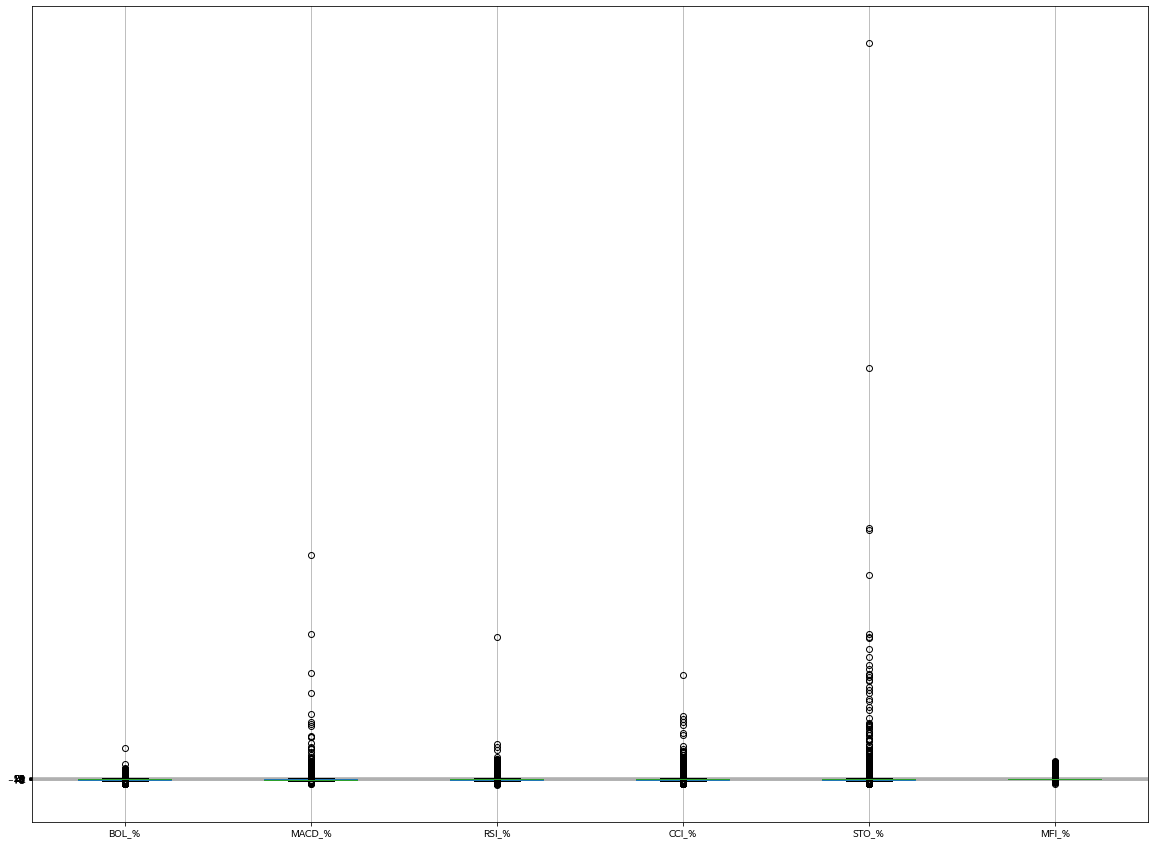

In [194]:
import matplotlib.pyplot as plt
plt.figure(figsize = (20,15))
boxplot = trade_data.boxplot(column = ['BOL_%', 'MACD_%','RSI_%','CCI_%','STO_%', 'MFI_%'])
plt.yticks(np.arange(-10, 30, step=3))
plt.show

In [195]:
print(trade_data['BOL_%'].mean())
print(trade_data['MACD_%'].mean())
print(trade_data['RSI_%'].mean())
print(trade_data['CCI_%'].mean())
print(trade_data['STO_%'].mean())
print(trade_data['MFI_%'].mean())

# stock_from = "20200731" # 2249~2301
# stock_to = "20220701"
# 8.65380358778749
# 13.431442535451176
# 10.337464738962936
# 14.054430406162439
# 13.900234516943659
# 3.152631697118589

-0.13721646863634418
-4.912674475585548
-2.3822016727046793
-3.5149678847689074
-3.4344303252132073
-0.18362810722661607


In [196]:
trade_data[trade_data['MFI'] < 20]

,level_0,index,날짜,Open,High,Low,Close,Volume,종목명,ma20,...,CCI_bool,STO_bool,MFI_bool,trend,BOL_%,MACD_%,RSI_%,CCI_%,STO_%,MFI_%
1090,1090,1318,2021-11-11,12000,12350,11700,11850,89597,AP위성,13585.00,...,-1,1,1,-1,-23.792121,-11.120606,-15.159394,-23.481970,-16.998485,0.0
5226,5434,6460,2021-10-07,3025,3100,3010,3065,56734,CNH,3557.00,...,1,-1,-1,1,-6.412000,-6.563850,-12.925033,-3.006117,-11.358300,0.0
9370,9994,11856,2021-09-09,5600,5750,5550,5600,707643,DSC인베스트먼트,5447.50,...,-1,1,0,-1,0.000000,0.358400,0.000000,2.940800,2.752000,0.0
9726,10350,12250,2022-04-20,6250,6390,6170,6370,143015,DSR,6280.50,...,1,-1,-1,1,5.688200,21.886867,10.534511,-8.746911,1.325989,0.0
11118,11950,14154,2022-01-13,1765,1820,1740,1760,262214,EV수성,1932.00,...,1,-1,1,-1,3.488821,-10.813128,-1.201256,-19.886090,-11.424115,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458881,517121,611627,2021-10-19,12750,13400,12750,13200,571292,휴마시스,14487.50,...,1,-1,-1,1,-1.356364,-16.112121,-17.284848,-11.700000,-21.497121,0.0
461337,520409,615485,2022-06-23,6780,6830,6110,6140,283698,흥국,8091.00,...,-1,1,1,-1,-1.324646,-0.418375,2.767500,-14.105438,-9.745813,0.0
461520,520592,615706,2022-05-17,3740,3810,3710,3755,360777,흥국에프엔비,4164.75,...,-1,1,-1,1,28.055478,-11.993600,12.366689,7.761511,19.642911,0.0
462353,521633,616937,2022-05-18,7850,7980,7750,7750,175469,희림,8209.50,...,1,1,-1,1,44.765022,-4.023822,24.319889,-7.108333,-7.331556,0.0


In [197]:
trade_data['MFI_%'][1000:1100]

1000    0.0
1001    0.0
1002    0.0
1003    0.0
1004    0.0
       ... 
1095    1.6
1096    2.4
1097    0.0
1098   -2.0
1099    0.4
Name: MFI_%, Length: 100, dtype: float64

In [198]:
len_a3

NameError: name 'len_a3' is not defined

In [ ]:
(len(df[df['종목명'] == dname[0]])-38)

In [199]:
MACD_c

32343

In [200]:
BOL_c

26663

In [201]:
STO_c

152463

In [202]:
MFI_c

9051

In [203]:
CCI_c

52788

In [204]:
RSI_c

30543